In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.io

In [ ]:
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Mounted at /gdrive


In [ ]:
%cd ..
%cd gdrive/MyDrive/image_proj

/
/gdrive/MyDrive/image_proj


In [ ]:
train = scipy.io.loadmat('train_32x32.mat')
test = scipy.io.loadmat('test_32x32.mat')

X_train, y_train = train['X'], [int(i) for i in train['y']]
X_test, y_test = test['X'], [int(j) for j in test['y']]

print(X_train.shape)

(32, 32, 3, 73257)


In [ ]:
# move last axis to front
X_train = np.rollaxis(X_train, -1)
X_test = np.rollaxis(X_test, -1)

# change 10 to 0 and keep as list of ints
y_train = [0 if i == 10 else i for i in y_train]
y_test = [0 if i == 10 else i for i in y_test]

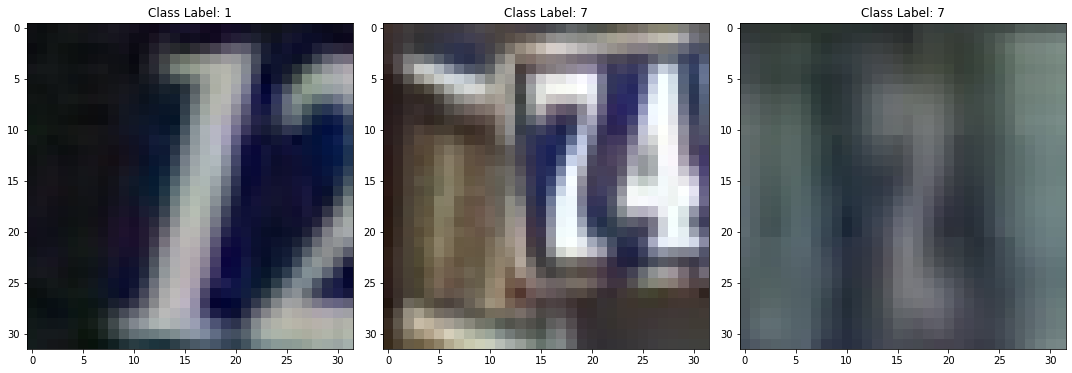

In [ ]:
# visualize some data and labels
import random
rands = [random.randint(0, X_train.shape[0]) for i in range(4)]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(X_train[rands[0]])
ax[0].set_title('Class Label: ' + str(y_train[rands[0]]))

ax[1].imshow(X_train[rands[1]])
ax[1].set_title('Class Label: ' + str(y_train[rands[1]]))

ax[2].imshow(X_train[rands[2]])
ax[2].set_title('Class Label: ' + str(y_train[rands[2]]))

plt.tight_layout()

In [ ]:
num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, random_state=42) 

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', padding='same', input_shape= (32, 32, 3)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         7

In [ ]:
batch_size = 32
epochs = 5
history = model.fit(X_train1, y_train1, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/5
1946/1946 [==============================] - 11s 5ms/step - loss: 0.7554 - accuracy: 0.7717 - val_loss: 0.3790 - val_accuracy: 0.8892
Epoch 2/5
1946/1946 [==============================] - 11s 6ms/step - loss: 0.3923 - accuracy: 0.8861 - val_loss: 0.3545 - val_accuracy: 0.8972
Epoch 3/5
1946/1946 [==============================] - 10s 5ms/step - loss: 0.3365 - accuracy: 0.9016 - val_loss: 0.3213 - val_accuracy: 0.9067
Epoch 4/5
1946/1946 [==============================] - 11s 5ms/step - loss: 0.2928 - accuracy: 0.9136 - val_loss: 0.3007 - val_accuracy: 0.9136
Epoch 5/5
1946/1946 [==============================] - 10s 5ms/step - loss: 0.2708 - accuracy: 0.9198 - val_loss: 0.2832 - val_accuracy: 0.9180


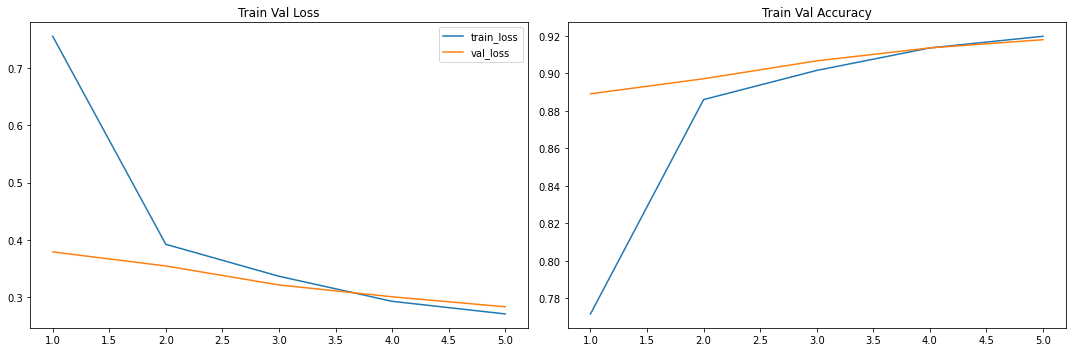

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].set_title('Train Val Loss')
ax[0].plot(range(1, epochs+1), history.history['loss'], label='train_loss')
ax[0].plot(range(1, epochs+1), history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].set_title('Train Val Accuracy')
ax[1].plot(range(1, epochs+1), history.history['accuracy'], label='train_acc')
ax[1].plot(range(1, epochs+1), history.history['val_accuracy'], label='val_acc')

plt.tight_layout()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
score[1]

0.9160264134407043

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.6MB/s 


In [ ]:
import kerastuner as kt
from keras import backend as K
import shutil
shutil.rmtree('my_dir/svhn_proj', ignore_errors=True)

def build_model(hp):
  hp_filters = hp.Int('filters', 128, 256, step=32)
  hp_kernel = hp.Int('kernel', min_value=3, max_value=7, step=1)
  hp_choice = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2,
                        sampling='LOG', default=1e-3)
  hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.05)
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32, 3, activation='relu', padding='same', input_shape= (32, 32, 3)))
  model.add(layers.Conv2D(32, 3, activation='relu'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
  model.add(layers.Conv2D(64, 3, activation='relu'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Conv2D(hp_filters, hp_kernel, activation='relu', padding='same'))
  model.add(layers.Conv2D(hp_filters, hp_kernel, activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(hp_dropout))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_choice),
                loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 5,
                     seed = 42,
                     directory = 'my_dir',
                     project_name = 'svhn_proj')  

tuner.search(X_train1, y_train1, epochs = 5, validation_data = (X_val, y_val))
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hp.get('filters'), best_hp.get('kernel'), best_hp.get('learning_rate'), best_hp.get('dropout'))

Trial 10 Complete [00h 01m 18s]
val_accuracy: 0.9230139255523682

Best val_accuracy So Far: 0.9230139255523682
Total elapsed time: 00h 07m 18s
INFO:tensorflow:Oracle triggered exit
256 4 0.00014023399602325874 0.20000000000000004


In [ ]:
model_tuned = tuner.hypermodel.build(best_hp)
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)         2

In [ ]:
history_tuned = model_tuned.fit(X_train1, y_train1, epochs = 5, validation_data = (X_val, y_val))

Epoch 1/5
1946/1946 [==============================] - 15s 8ms/step - loss: 0.7174 - accuracy: 0.7870 - val_loss: 0.4512 - val_accuracy: 0.8711
Epoch 2/5
1946/1946 [==============================] - 15s 8ms/step - loss: 0.3620 - accuracy: 0.8971 - val_loss: 0.3303 - val_accuracy: 0.9073
Epoch 3/5
1946/1946 [==============================] - 15s 8ms/step - loss: 0.2687 - accuracy: 0.9243 - val_loss: 0.2930 - val_accuracy: 0.9178
Epoch 4/5
1946/1946 [==============================] - 15s 8ms/step - loss: 0.2045 - accuracy: 0.9425 - val_loss: 0.2926 - val_accuracy: 0.9225
Epoch 5/5
1946/1946 [==============================] - 15s 8ms/step - loss: 0.1545 - accuracy: 0.9551 - val_loss: 0.2960 - val_accuracy: 0.9252


In [ ]:
score_tuned = model_tuned.evaluate(X_test, y_test, verbose=0)
score_tuned[1]

0.9156807065010071

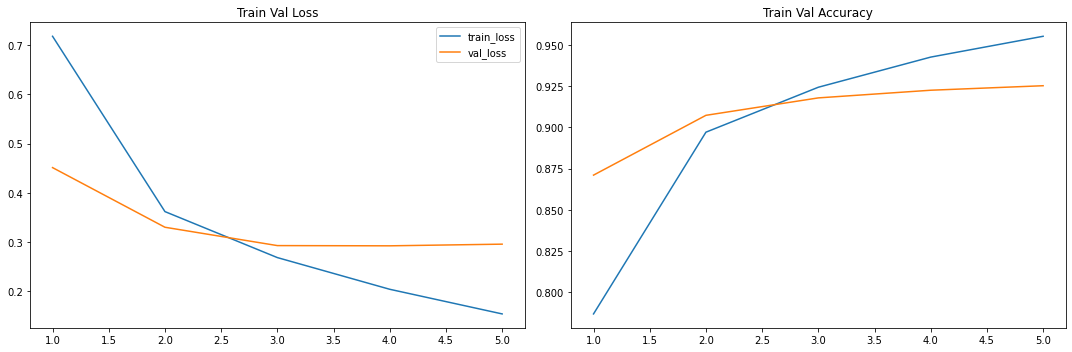

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].set_title('Train Val Loss')
ax[0].plot(range(1, epochs+1), history_tuned.history['loss'], label='train_loss')
ax[0].plot(range(1, epochs+1), history_tuned.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].set_title('Train Val Accuracy')
ax[1].plot(range(1, epochs+1), history_tuned.history['accuracy'], label='train_acc')
ax[1].plot(range(1, epochs+1), history_tuned.history['val_accuracy'], label='val_acc')

plt.tight_layout()